# Motor simulation

Insparation from: 

* [DC Motor model in spice](http://www.ecircuitcenter.com/Circuits/dc_motor_model/DCmotor_model.htm)
* [Wiki page on LR Circuit](https://en.wikipedia.org/wiki/RL_circuit)

## The model

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math

class Supply:
    def __init__(self):
        self.amperage = 0
        self.voltage = 0

class Load:
    def __init__(self):
        self.inertia = 0
        self.friction = 0

class Motor:
    """
    DC motor simulator. 
    
    ra   : Armature resistance [Ohm]
    la   : Armature inductance [Henry]
    kt   : Torque constant [Nm/A]
    kemf : Electromotive force (back EMF) constant [V/rad/s]
    jm   : Motor angular momentum [kg*m**2]
    bm   : Motor friction [Nm/rad/s]
    
    """
    def __init__(self, ra, la, kt, kemf, jm, bm):
        self.__ra = ra
        self.__la = la
        
        self.__kt = kt
        self.__kemf = kemf
        
        self.__jm = jm
        self.__bm = bm

        # Internal variables
        self.__ia = 0
        self.__ib = 0

        # Runtime parameters
        self.supply = Supply()
        self.load = Load()

    def torque(self):
        return self.__kt * self.__ia
    
    def angular_velocity(self):
        return self.__ib
    
    def step(self, dt):
        self.__step_environment(dt)
        self.__step_motor(dt)
        
    def __step_motor(self, dt):
        # "Correct" the input voltage for the current load aka "back EMF"
        v = self.supply.voltage - self.__kemf*self.__ib
        l = self.__la
        r = self.__ra
        
        e = math.exp(-r/l*dt)
        self.__ia = self.__ia*e + v/r*(1-e)

    def __step_environment(self, dt):
        v = self.torque()
        l = self.__jm + self.load.inertia  # inertia
        r = self.__bm + self.load.friction # friction
                   
        e = math.exp(-r/l*dt)            
        self.__ib = self.__ib*e + v/r*(1-e)


### Helper functions

In [2]:
def run(motor, dt, time, action):
    for i in range(0, int(time/dt)):
        motor.step(dt)
        action()

Some helper function for aid with logging/plotting

In [3]:
def log_action():
    # TODO: Is there a better way to define a "capture list"?
    global data
    global motor
    global index
    
    data[0, index] = motor.angular_velocity()
    data[1, index] = motor.torque()
    index = index+1
    
def plot(data):
    plt.plot(data[0,:], label="angular velocity [rad/s]")
    plt.plot(data[1,:], label="torque [Nm]")
    plt.legend()
    plt.xlabel("time [ms]")
    plt.grid(True)
    plt.show()


## The first simulation

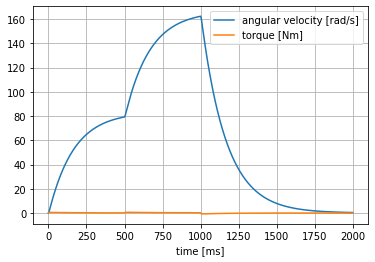

In [4]:
# Motor parameters
R_A = 0.5        # Terminal resistance [Ohm]
L_A = 0.0015     # Terminal inductance [Henry]
K_T = 0.05       # Torque constant [Nm/A]
K_EMF = 0.05     # Electromotive force (back EMF) constant [V/rad/s]
B_M = 0.001      # Friction [Nm/rad/s]
J_M = 0.001      # Inertia [kg*m**2]

# Simulation parameters
dt = 0.001       # Time step [s]; 0.001 s = 1 ms
total_time = 2   # Total time for simulation [s]
data = np.zeros((2, int(total_time/dt)))
index = 0    

motor = Motor(R_A, L_A, K_T, K_EMF, J_M, B_M)


motor.supply.voltage = 5
run(motor, dt, 0.5, log_action)

motor.supply.voltage = 10
run(motor, dt, 0.5, log_action)

motor.supply.voltage = 0
run(motor, dt, 1, log_action)

plot(data)

## Another motor
Testing with parameters for a random motor found on the internet: 
https://www.researchgate.net/figure/DC-motor-parameters_tbl1_327366778

![](https://www.researchgate.net/profile/Zain_Aldeen_S_A_Rahman/publication/327366778/figure/tbl1/AS:670536782868496@1536879835405/DC-motor-parameters.png)

Notice the top speed of ~160 rad/s; this is ~1500 rpm as also stated in the motor parameters

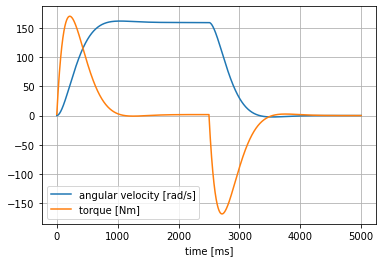

In [5]:
# Data from the motor parameter sheet
R_A = 0.4      # Terminal resistance [Ohm]
L_A = 0.05     # Terminal inductance [Henry]
K_T = 0.5      # Torque constant [Nm/A]
K_EMF = 1.25   # Electromotive force (back EMF) constant [V/rad/s]
B_M = 0.01     # Friction [Nm/rad/s]
J_M = 0.5      # Angular momentum [kg*m**2]

total_time = 5
dt = 0.001
    
data = np.zeros((2, int(total_time/dt)))
index = 0

## Create a motor and run a scenario
motor = Motor(R_A, L_A, K_T, K_EMF, J_M, B_M)

motor.supply.voltage = 200 # Max rated armature voltage
run(motor, dt, 2.5, log_action)
motor.supply.voltage = 0
run(motor, dt, 2.5, log_action)

plot(data)


### Varying load

This scenario uses the same motor as above (hence no motor parameters). In this scenario the load is varied using `motor.load.inertia` and `motor.load.friction`.

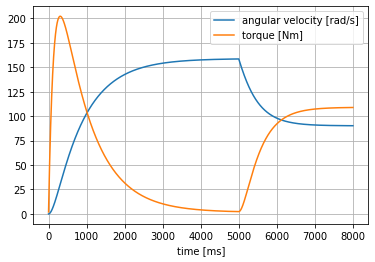

In [16]:
## Simulation parameters
total_time = 8
data = np.zeros((2, int(total_time/dt)))
index = 0

motor = Motor(R_A, L_A, K_T, K_EMF, J_M, B_M)

## Run a scenario with varying load
motor.supply.voltage = 200
motor.load.inertia = 1
run(motor, dt, 5, log_action)
motor.load.friction = 1.2 # Add some load
run(motor, dt, 3, log_action)

plot(data)

### Free running
Simulate that the supply voltage is remove by setting the current limiter to 0.

In [17]:
# TODO...